 전처리 및 데이터셋 생성

In [1]:
import pandas as pd
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration
import torch
import re

# ✅ 요약 모델 로드 (KoBART)
summary_tokenizer = PreTrainedTokenizerFast.from_pretrained("digit82/kobart-summarization")
summary_model = BartForConditionalGeneration.from_pretrained("digit82/kobart-summarization")
summary_model.eval()

# ✅ 본문 슬라이딩 함수
def sliding_window(text, window=300, step=150):
    words = text.split()
    slices = []
    for i in range(0, len(words), step):
        part = words[i:i+window]
        if part:
            slices.append(' '.join(part))
        if i + window >= len(words):
            break
    return slices

# ✅ 슬라이스 각각 요약
def summarize_slices(slices):
    summaries = []
    for chunk in slices:
        inputs = summary_tokenizer(chunk, return_tensors="pt", max_length=512, truncation=True)
        with torch.no_grad():
            summary_ids = summary_model.generate(
                inputs['input_ids'],
                max_length=64,
                num_beams=4,
                early_stopping=True
            )
        summary = summary_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

# ✅ 전체 요약 실행
def generate_summary(body_text):
    # 토큰 개수 기준으로 길이 판단
    tokenized = summary_tokenizer(body_text, return_tensors="pt", truncation=False)
    if tokenized['input_ids'].shape[1] <= 512:
        return body_text  # 요약 없이 원문 그대로 사용
    else:
        slices = sliding_window(body_text)
        summaries = summarize_slices(slices)
        return ' '.join(summaries)
        
# ✅ 전체 데이터셋 처리 함수
def prepare_dataset(csv_path):
    df = pd.read_csv(csv_path)

    def preprocess_text(text):
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    df['title'] = df['title'].apply(preprocess_text)
    df['body'] = df['body'].apply(preprocess_text)
    df['summary'] = df['body'].apply(generate_summary)

    return df


tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

학습

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
# from preprocessing import prepare_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 데이터 불러오기
train_df = prepare_dataset('Kobert_data/train_dataset.csv')
val_df = prepare_dataset('Kobert_data/val_dataset.csv')


# 2. Dataset 클래스 정의
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        title = self.data.iloc[idx]['title']
        summary = self.data.iloc[idx]['summary']   # 리스트
        label = int(self.data.iloc[idx]['label'])

        inputs = self.tokenizer(
            title,
            summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 3. 준비
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")

train_dataset = NewsDataset(train_df, tokenizer)
val_dataset = NewsDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:

# 4. 학습 루프
for epoch in range(7):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

100%|██████████| 471/471 [02:52<00:00,  2.74it/s]


Epoch 1 Loss: 0.6596


100%|██████████| 471/471 [02:52<00:00,  2.73it/s]


Epoch 2 Loss: 0.6012


100%|██████████| 471/471 [02:52<00:00,  2.73it/s]


Epoch 3 Loss: 0.5727


100%|██████████| 471/471 [02:52<00:00,  2.73it/s]


Epoch 4 Loss: 0.5404


100%|██████████| 471/471 [02:52<00:00,  2.73it/s]


Epoch 5 Loss: 0.5074


100%|██████████| 471/471 [02:52<00:00,  2.73it/s]


Epoch 6 Loss: 0.4767


100%|██████████| 471/471 [02:52<00:00,  2.73it/s]

Epoch 7 Loss: 0.4252


In [5]:
from sklearn.metrics import precision_score, recall_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print(f"[Validation] Accuracy: {acc:.4f}  Precision: {precision:.4f}  Recall: {recall:.4f}  F1: {f1:.4f}")


Validation: 100%|██████████| 118/118 [00:15<00:00,  7.76it/s]

[Validation] Accuracy: 0.8434  Precision: 0.9295  Recall: 0.7242  F1: 0.8141


In [6]:
# 5. 저장
model.save_pretrained("./kmodel1")
tokenizer.save_pretrained("./kmodel1")
# 모델 저장


('./kmodel1/tokenizer_config.json',
 './kmodel1/special_tokens_map.json',
 './kmodel1/vocab.txt',
 './kmodel1/added_tokens.json')

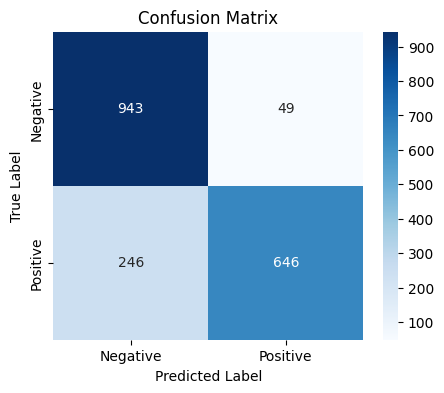

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 2. 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8434
Precision: 0.9295
Recall:    0.7242
F1 Score:  0.8141


In [10]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.79      0.95      0.86       992
    Positive       0.93      0.72      0.81       892

    accuracy                           0.84      1884
   macro avg       0.86      0.84      0.84      1884
weighted avg       0.86      0.84      0.84      1884



모델의 정확도를 더 높이기 위한 추가 학습(fine-tuning)

In [4]:
import pandas as pd

# 엑셀 파일 읽기
df_extra = pd.read_excel('/teamspace/studios/this_studio/random_30개_김대중리뷰.xlsx')

# 내용 확인
print(df_extra.head())

   Unnamed: 0                                     title  \
0        1408                      민주당, 곧바로 조기 대선 체제 전환   
1         680                                   상인들의 고충   
2        1565  [자막뉴스] 단체방에서 오고간 '날 선 발언'...계파 갈등으로 분열하나   
3        2265               [포토] 개헌 관련 긴급 담화하는 우원식 국회의장   
4        2110   우원식 개헌 동시 투표 주장에 민주 친명 “내란종식 우선” 반발(종합)   

                                                body reporter  \
0  [앵커]\n더불어민주당은 그동안 물밑에서 대선 실무 작업을 진행을 해 왔습니다.\n...   정연주 기자   
1  (서울=연합뉴스) 임화영 기자 = 윤석열 대통령 탄핵 심판 선고일을 이틀 앞둔 2일...   임화영 기자   
2  윤 전 대통령 파면 직후 의원총회에서 신임을 사실상 재확인한 '쌍권' 지도부, 두 ...      NaN   
3  우원식 국회의장이 6일 국회 사랑재에서 개헌관련 긴급 담화를 하고 있다.2025.4...   김호영 기자   
4  우원식 국회의장이 6일 긴급 기자회견에서 개헌 국민투표를 대통령 선거와 동시에 진행...   김태경 기자   

                                                 URL media  공감1  공감2  공감3  \
0  https://n.news.naver.com/mnews/article/449/000...   채널A    2    0    0   
1  https://n.news.naver.com/mnews/article/001/001...  연합뉴스    0    0    0   
2  https://n.news.naver